## Trying Bulk API

In [ ]:
# pip install deweydatapy

In [2]:
import gzip
import os
import sys
from io import BytesIO

import pandas as pd
import requests
from datetime import datetime

def __make_api_endpoint(path):
    # remove trailing spaces
    path = path.strip()
    if not path.startswith("https://"):
        api_endpoint = f"https://app.deweydata.io/external-api/v3/products/{path}/files"
        return api_endpoint
    else:
        return path

def get_meta(apikey, product_path, print_meta=True):
    """
    Collects the meta information from data server.

    :param apikey: API Key.
    :param product_path: API endpoint or Product ID.
    :param print_meta: Print meta information. Default is True.
    :return: A DataFrame object contains meta information.
    """
    product_path = __make_api_endpoint(product_path)
    try:
        response = requests.get(url=product_path+"/metadata",
                                headers={'X-API-KEY': apikey,
                                         'accept': 'application/json'})
    except Exception as e:
        print("Error in requests.get")
        print(e)
        print(" ")
        return None

    if response is None:
        return None
    elif response.status_code == 401:
        print(response)
        return None

    res_json = response.json()

    if 'total_files' not in res_json:
        print("Error in response.json")
        print(res_json)
        print(" ")
        return None

    meta = res_json
    # total_size is in mega bytes
    meta['total_size'] = meta['total_size'] / 1000000
    # Rename total_size to total_size_MB
    meta['total_size_MB'] = meta.pop('total_size')

    # Convert res_json to a DataFrame
    # meta = pd.DataFrame(res_json, index=[0])
    # # total_size is in mega bytes
    # meta['total_size'] = meta['total_size'] / 1000000
    # # change total_size to total_size_MB
    # meta.rename(columns={'total_size': 'total_size_MB'}, inplace=True)

    # meta = pd.DataFrame({
    #     'total_files': [res_json['total_files']],
    #     'total_pages': [res_json['total_pages']],
    #     'total_size': [res_json['total_size'] / 1000000],
    #     'expires_at': [res_json['expires_at']]
    # })

    if print_meta:
        print(" ")
        print("Metadata summary ------------------------------------------------")
        print("Total number of files: {:,}".format(meta['total_files']))
        print("Total files size (MB): {:,}".format(round(meta['total_size_MB'], 2)))
        print(f"Date aggregation: {meta['partition_aggregation']}")
        print(f"Date partition column: {meta['partition_column']}")
        print(f"Data min available date: {meta['min_partition_key']}")
        print(f"Data max available date: {meta['max_partition_key']}")
        print("-----------------------------------------------------------------")
        print(" ")
    return meta

def print_selection_meta(selection_meta, pages_meta):
    print("Files information summary ---------------------------------------")
    print("Total number of pages: {:,}".format(selection_meta['total_pages'].values[0]))
    print("Total number of files: {:,}".format(selection_meta['total_files'].values[0]))
    print("Total files size (MB): {:,}".format(round(selection_meta['total_size_MB'].values[0], 2)))
    print("Average single file size (MB): {:,}".format(round(pages_meta['avg_file_size_for_page_MB'].mean(), 2)))
    print(f"Date partition column: {pages_meta['partition_column'].values[0]}")
    print(f"Expires at: {selection_meta['expires_at'].values[0]}")
    print("-----------------------------------------------------------------")
    sys.stdout.flush()

def get_file_list_full(apikey, product_path, start_page=1, end_page=float('inf'),
                  start_date=None, end_date=None,
                  meta=None,
                  print_info=True):
    """
    Collects the file list information from data server.

    :param apikey: API Key.
    :param product_path: API endpoint or Product ID.
    :param start_page: Start page of file list. Default is 1.
    :param end_page: End page of file list. Default is Inf.
    :param start_date: Data start date character for files in the form of '2021-07-01'. Default is None ("1000-01-01"), which indicates no limit.
    :param end_date: Data end date character for files in the form of '2023-08-21'. Default is None ('9999-12-31'), which indicates no limit.
    :param print_info: Print file list information. Default is True.
    :return: DataFrame object contains files information, selection meta and pages meta.
    """

    product_path = __make_api_endpoint(product_path)
    if(meta is None):
        meta = get_meta(apikey, product_path, print_meta=False)

    selection_meta = None
    pages_meta = None
    files_df = None

    if start_date is None:
        start_date = "1000-01-01"
    if end_date is None:
        end_date = "9999-12-31"

    # To proper date format: for example '2023-3-4' to '2023-03-04'
    start_date = datetime.strptime(start_date, '%Y-%m-%d').strftime('%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d').strftime('%Y-%m-%d')

    page = start_page
    while True:
        if(meta['partition_column'] is None):
            params_ = {'page': page}
        else:
            params_ = {'page': page,
                       'partition_key_after': start_date,
                       'partition_key_before': end_date}
        try:
            response = requests.get(url=product_path,
                                    params=params_,
                                    headers={'X-API-KEY': apikey,
                                             'accept': 'application/json'})
        except Exception as e:
            print("Error in requests.get")
            print(e)
            print(" ")
            return None

        if response is None:
            return None
        elif response.status_code == 401:
            print(response)
            return None
        elif response.status_code == 422:
            print(response)
            return None

        res_json = response.json()
        if 'page' not in res_json:
            print("Error in response.json")
            print(res_json)
            print(" ")
            return None

        # Initialize
        if res_json['page'] == start_page:
            selection_meta = pd.DataFrame({
                'total_files': [res_json['total_files']],
                'total_pages': [res_json['total_pages']],
                'total_size_MB': [res_json['total_size'] / 1000000],
                'expires_at': [res_json['expires_at']]
            })

        if(print_info == True):
            print(f"Collecting files information for page {res_json['page']}/{res_json['total_pages']}...")

        pages_meta = pd.concat([
            pages_meta,
            pd.DataFrame({
                'page': [res_json['page']],
                'number_of_files_for_page': [res_json['number_of_files_for_page']],
                'avg_file_size_for_page_MB': [res_json['avg_file_size_for_page'] / 1000000],
                'partition_column': [res_json['partition_column']]
            })], ignore_index=True)

        page_files_df = pd.DataFrame(res_json['download_links'])

        page_files_df.insert(loc=0, column='page', value=res_json['page'])

        files_df = pd.concat([files_df, page_files_df], ignore_index=True)

        page = res_json['page'] + 1

        sys.stdout.flush()

        if page > res_json['total_pages'] or page > end_page:
            if(print_info == True):
                print("Files information collection completed.")
                sys.stdout.flush()
            break

    # Backward compatibility
    files_df['download_link'] = files_df['link']
    # Attach index
    files_df.insert(loc=0, column='index', value=range(0, files_df.shape[0]))

    if print_info == True:
        print(" ")
        print_selection_meta(selection_meta, pages_meta)
        # print("\nFiles information summary ---------------------------------------")
        # print("Total number of pages: {:,}".format(selection_meta['total_pages'].values[0]))
        # print("Total number of files: {:,}".format(selection_meta['total_files'].values[0]))
        # print("Total files size (MB): {:,}".format(round(selection_meta['total_size_MB'].values[0], 2)))
        # print("Average single file size (MB): {:,}".format(round(pages_meta['avg_file_size_for_page_MB'].mean(), 2)))
        # print(f"Date partition column: {pages_meta['partition_column'].values[0]}")
        # print(f"Expires at: {selection_meta['expires_at'].values[0]}")
        # print("-----------------------------------------------------------------\n")
        # sys.stdout.flush()

    return files_df, selection_meta, pages_meta

def get_file_list(apikey, product_path, start_page=1, end_page=float('inf'),
                  start_date=None, end_date=None,
                  meta=None,
                  print_info=True):
    """
    Collects the file list information from data server.

    :param apikey: API Key.
    :param product_path: API endpoint or Product ID.
    :param start_page: Start page of file list. Default is 1.
    :param end_page: End page of file list. Default is Inf.
    :param start_date: Data start date character for files in the form of '2021-07-01'. Default is None ("1000-01-01"), which indicates no limit.
    :param end_date: Data end date character for files in the form of '2023-08-21'. Default is None ('9999-12-31'), which indicates no limit.
    :param print_info: Print file list information. Default is True.
    :return: A DataFrame object contains files information.
    """

    files_df, selection_meta, pages_meta = get_file_list_full(apikey, product_path,
                                                        start_page, end_page,
                                                        start_date, end_date,
                                                        meta,
                                                        print_info)

    return files_df

def read_sample(url, nrows=100):
    """
    Read sample data into memory from a URL.

    :param url: A file URL.
    :param nrows: Number of rows to read. Default is 100.
    :return: A DataFrame object contains data.
    """

    # if(nrows > 1000) {
    #   print("Warning: set nrows no greater than 1000.");
    #   nrows = 1000;
    # }

    # Create a response object from the URL
    response = requests.get(url)

    try:
        df = pd.read_csv(BytesIO(response.content), compression="gzip", nrows=nrows)
    except gzip.BadGzipFile:  # not gzip file. try normal csv
        df = pd.read_csv(BytesIO(response.content), nrows=nrows)
    except:
        print("Could not read the data. Can only open gzip csv file or csv file.")

    return (df)

# Backward compatibility
read_sample_data = read_sample


# Read first file data into memory
def read_sample0(apikey, product_path, nrows=100):
    """
    Read first file data into memory using API key and product path.
    :param apikey: API key.
    :param product_path: API endpoint or Product ID.
    :param nrows: Number of rows to read. Default is 100.
    :return: A DataFrame object contains data.
    """
    files_df = get_file_list(apikey, product_path, start_page=1, end_page=1, print_info=True)

    if not (files_df is None) & (files_df.shape[0] > 0):
        return read_sample_data(files_df["link"][0], nrows)
    else:
        return None

# Backward compatibility
read_sample_data0 = read_sample0

# Download files from file list to a destination folder
def download_files(files_df, dest_folder, filename_prefix=None, skip_exists=False):
    """
    Download files from file list to a destination folder.

    :param files_df: File list collected from get_file_list.
    :param dest_folder: Destination local folder to save files.
    :param filename_prefix: Prefix for file names.
    :param skip_exists: Skips downloading if the file. Default is True.
    :return: void.
    """
    dest_folder = dest_folder.replace("\\", "/")
    if (not (dest_folder.endswith("/"))):
        dest_folder = dest_folder + "/"

    if filename_prefix is None:
        filename_prefix = ""

    files_df.reset_index(drop=True, inplace=True)

    # number of files
    num_files = files_df.shape[0]

    for i in range(0, num_files):
        print(f"Downloading {i + 1}/{num_files} (file index = {files_df['index'][i]})")

        file_name = filename_prefix + files_df['file_name'][i]
        dest_path = dest_folder + file_name

        if os.path.exists(dest_path) and skip_exists:
            print(f"File already exists: {dest_path}")
            print(f"Skipping...")
            continue

        print(f"Writing {dest_path}")
        print("Please be patient. It may take a while...")
        sys.stdout.flush()

        response = requests.get(files_df['link'][i])
        open(dest_path, 'wb').write(response.content)
        print(f"   ")
        sys.stdout.flush()


def download_files0(apikey, product_path, dest_folder,
                    start_date=None, end_date=None,
                    filename_prefix=None, skip_exists=False):
    """
    Download files with API key and product path to a destination folder.

    :param apikey: API Key.
    :param product_path: API endpoint or Product ID.
    :param dest_folder: Destination local folder to save files.
    :param start_date: Data start date character for files in the form of '2021-07-01'. Default is None ("1000-01-01"), which indicates no limit.
    :param end_date: Data end date character for files in the form of '2023-08-21'. Default is None ('9999-12-31'), which indicates no limit.
    :param filename_prefix: Prefix for file names.
    :param skip_exists: Prefix for file names. Skips downloading if the file exists. Default is True.
    :return:
    """
    files_df = get_file_list(apikey, product_path,
                             start_page=1, end_page=float('inf'),
                             start_date=start_date, end_date=end_date,
                             print_info=True)
    # print("   ")
    print("Start downloading...")
    print(" ")

    if files_df is not None and files_df.shape[0] > 0:
        download_files(files_df, dest_folder, filename_prefix, skip_exists)
    else:
        print("No files to download.")

    print(" ")
    print("Download completed.")

def download_files1(apikey, product_path, dest_folder,
                    start_date=None, end_date=None,
                    filename_prefix=None, skip_exists=False):
    """
    Download files with API key and product path to a destination folder.

    :param apikey: API Key.
    :param product_path: API endpoint or Product ID.
    :param dest_folder: Destination local folder to save files.
    :param start_date: Data start date character for files in the form of '2021-07-01'. Default is None ("1000-01-01"), which indicates no limit.
    :param end_date: Data end date character for files in the form of '2023-08-21'. Default is None ('9999-12-31'), which indicates no limit.
    :param filename_prefix: Prefix for file names.
    :param skip_exists: Prefix for file names. Skips downloading if the file exists. Default is True.
    :return:
    """

    # Get meta data
    meta = get_meta(apikey, product_path, print_meta=False)

    # Call get_file_list with meta for the first page to see the total_pages
    p1_files_df, p1_selection_meta, p1_pages_meta = \
        get_file_list_full(apikey=apikey, product_path=product_path,
                                start_page=1, end_page=1,
                                start_date=start_date, end_date=end_date,
                                meta=meta,
                                print_info=False)
    print_selection_meta(p1_selection_meta, p1_pages_meta)

    selection_meta = p1_selection_meta

    print(" ")
    print("Start downloading...")
    for i in range(1, selection_meta['total_pages'][0] + 1):
        print(" ")
        print("Downloading page {}/{}...".format(i, selection_meta['total_pages'][0]))

        files_df = get_file_list(apikey=apikey, product_path=product_path,
                                 start_page=i, end_page=i,
                                 start_date=start_date, end_date=end_date,
                                 meta=meta,
                                 print_info=False)

        download_files(files_df, dest_folder, filename_prefix, skip_exists)

    print(" ")
    print("Download completed.");

def slice_files_df(files_df, start_date, end_date=None):
    """
    Slice files_df from get_file_list for specific data range of from start_date to end_date.
    For example, start_date = "2023-08-14", end_date = "2023-08-21".

    :param files_df: files_df from get_file_list.
    :param start_date: Start date character for files in the form of "2023-08-21".
    :param end_date: End date character for files in the form of "2023-08-21".
    :return: A sliced DataFrame object contains files information.
    """

    if end_date is None:
        sliced_df = files_df[(start_date <= files_df['partition_key'])]
    else:
        sliced_df = files_df[(start_date <= files_df['partition_key']) &
                             (files_df['partition_key'] <= end_date)]

    return sliced_df


def read_local(path, nrows=None):
    """
    Read local data into memory from a path

    :param path: Path to a .csv.gz or csv file.
    :param nrows: Number of rows to read. Default is None (all).
    :return: A DataFrame object contains data.
    """
    df = pd.read_csv(path, nrows=nrows)
    return df

# Backward compatibility
read_local_data = read_local

def filter_data(data_folder, output_path, query=None, columns=None):
    """
    Filters data as each file is read and merges them into a single csv file based on query and columns input.

    :param data_folder: Folder where user has the downloaded files.
    :param ouput_path: File path for final file output.
    :param query: String containing query the columns of a pandas DataFrame with a boolean expression. Default is None, which indicates all rows.
    :param columns: Subset of columns to take from the DataFrame. Default is None, which indicates all columns.
    """

    try:
        if not os.path.exists(data_folder):
            raise FileNotFoundError(f"Data folder {data_folder} not found.")
        
        files = [file for file in os.listdir(data_folder) if file.endswith(".csv.gz") or file.endswith(".csv")]
        if not files:
            raise FileNotFoundError(f"No CSV files found in {data_folder}")
   
        df_list = []
        for i, file in enumerate(files):
            print(f"Processing File {i+1}/{len(files)}")
            file_path = os.path.join(data_folder, file)
            try: 
                df = pd.read_csv(file_path)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
                continue

            try:
                df = df if query is None else df.query(query)
                df = df if columns is None else df[columns]
                df_list.append(df)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
                continue
        df = pd.concat(df_list, ignore_index=True)

        print(f"Saving merged data to {output_path}...") # print the path where the merged data will be saved
        df.to_csv(output_path, index=False) # save the merged data to a CSV file
        print("Done!")

    except Exception as e:
        print(f"Error: {e}")

In [3]:
from dotenv import load_dotenv
import os
# Using library
# Not run

apikey_ = os.getenv('API_KEY')
pp_ = "https://app.deweydata.io/external-api/v3/products/5acc9f39-1ca6-4535-b3ff-38f6b9baf85e/files"
files_df = get_file_list(apikey_, pp_)

Files information collection completed.
 
Files information summary ---------------------------------------
Total number of pages: 8
Total number of files: 3,711
Total files size (MB): 769,670.27
Average single file size (MB): 207.41
Date partition column: DATE_RANGE_START
Expires at: 2025-02-14T20:32:02.269Z
-----------------------------------------------------------------


In [ ]:
##files_df.head()
##sliced_files_df = slice_files_df(files_df, "2021-09-01", "2021-09-01")

##download_files(sliced_files_df, "/Users/avani/Documents/Practicum/data/biztraf")

Writing /Users/avani/Documents/Practicum/data/biztraf/Monthly_Patterns_Foot_Traffic-125-DATE_RANGE_START-2021-09-01.csv.gz
Please be patient. It may take a while...
   
Writing /Users/avani/Documents/Practicum/data/biztraf/Monthly_Patterns_Foot_Traffic-126-DATE_RANGE_START-2021-09-01.csv.gz
Please be patient. It may take a while...


KeyboardInterrupt: 

In [22]:
import pandas as pd
import glob
import os

# Path to your directory
path = '/Users/avani/Documents/Practicum/data/biztraf'

# Get list of all .csv.gz files
all_files = glob.glob(os.path.join(path, "*.csv.gz"))

# Create empty list to store dataframes
dfs = []

# Read each file, filter for Philadelphia, and add to list
for filename in all_files:
    df = pd.read_csv(filename, compression='gzip')
    philly_df = df[df['CITY'] == 'Philadelphia']
    dfs.append(philly_df)
    print(f"Processed: {filename}")  # This helps track progress

# Concatenate all dataframes
combined_df = pd.concat(dfs, ignore_index=True)

print(f"Final dataset shape: {combined_df.shape}")

/var/folders/mm/m098rbs1529c7x072qh31ncw0000gn/T/ipykernel_37626/888711167.py:16: DtypeWarning: Columns (1,2,4,15,17,18,20,27,34,36,37,38,39,42,43,44,45,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, compression='gzip')


Processed: /Users/avani/Documents/Practicum/data/biztraf/Monthly_Patterns_Foot_Traffic-133-DATE_RANGE_START-2021-09-01.csv.gz


/var/folders/mm/m098rbs1529c7x072qh31ncw0000gn/T/ipykernel_37626/888711167.py:16: DtypeWarning: Columns (18,34,36,37,38,39,42,43,44,45,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, compression='gzip')


Processed: /Users/avani/Documents/Practicum/data/biztraf/Monthly_Patterns_Foot_Traffic-127-DATE_RANGE_START-2021-09-01.csv.gz


/var/folders/mm/m098rbs1529c7x072qh31ncw0000gn/T/ipykernel_37626/888711167.py:16: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, compression='gzip')


Processed: /Users/avani/Documents/Practicum/data/biztraf/Monthly_Patterns_Foot_Traffic-132-DATE_RANGE_START-2021-09-01.csv.gz


/var/folders/mm/m098rbs1529c7x072qh31ncw0000gn/T/ipykernel_37626/888711167.py:16: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, compression='gzip')


Processed: /Users/avani/Documents/Practicum/data/biztraf/Monthly_Patterns_Foot_Traffic-126-DATE_RANGE_START-2021-09-01.csv.gz


/var/folders/mm/m098rbs1529c7x072qh31ncw0000gn/T/ipykernel_37626/888711167.py:16: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, compression='gzip')


Processed: /Users/avani/Documents/Practicum/data/biztraf/Monthly_Patterns_Foot_Traffic-131-DATE_RANGE_START-2021-09-01.csv.gz


/var/folders/mm/m098rbs1529c7x072qh31ncw0000gn/T/ipykernel_37626/888711167.py:16: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, compression='gzip')


Processed: /Users/avani/Documents/Practicum/data/biztraf/Monthly_Patterns_Foot_Traffic-128-DATE_RANGE_START-2021-09-01.csv.gz


/var/folders/mm/m098rbs1529c7x072qh31ncw0000gn/T/ipykernel_37626/888711167.py:16: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, compression='gzip')


Processed: /Users/avani/Documents/Practicum/data/biztraf/Monthly_Patterns_Foot_Traffic-125-DATE_RANGE_START-2021-09-01.csv.gz


/var/folders/mm/m098rbs1529c7x072qh31ncw0000gn/T/ipykernel_37626/888711167.py:16: DtypeWarning: Columns (18,34,36,37,38,39,42,43,44,45,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, compression='gzip')


Processed: /Users/avani/Documents/Practicum/data/biztraf/Monthly_Patterns_Foot_Traffic-130-DATE_RANGE_START-2021-09-01.csv.gz


/var/folders/mm/m098rbs1529c7x072qh31ncw0000gn/T/ipykernel_37626/888711167.py:16: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, compression='gzip')


Processed: /Users/avani/Documents/Practicum/data/biztraf/Monthly_Patterns_Foot_Traffic-129-DATE_RANGE_START-2021-09-01.csv.gz
Final dataset shape: (10388, 53)


In [28]:
import geopandas as gpd
from shapely.geometry import Point

geometry = [Point(lon, lat) for lon,lat in zip(combined_df['LONGITUDE'],combined_df['LATITUDE'])]
phillysf = gpd.GeoDataFrame(combined_df, geometry=geometry,crs='EPSG:4326')

In [29]:
phillysf.head()

,PLACEKEY,PARENT_PLACEKEY,SAFEGRAPH_BRAND_IDS,LOCATION_NAME,BRANDS,STORE_ID,TOP_CATEGORY,SUB_CATEGORY,NAICS_CODE,LATITUDE,...,RELATED_SAME_MONTH_BRAND,POPULARITY_BY_HOUR,POPULARITY_BY_DAY,DEVICE_TYPE,NORMALIZED_VISITS_BY_STATE_SCALING,NORMALIZED_VISITS_BY_REGION_NAICS_VISITS,NORMALIZED_VISITS_BY_REGION_NAICS_VISITORS,NORMALIZED_VISITS_BY_TOTAL_VISITS,NORMALIZED_VISITS_BY_TOTAL_VISITORS,geometry
0,zzw-22m@628-pmf-j7q,NaN,NaN,Gomez Law Group,NaN,NaN,"Justice, Public Order, and Safety Activities",Courts,922110,39.950657,...,"{""Western Union"":1057,""Starbucks"":954,""Dunkin'...","[47,41,36,29,34,51,77,84,209,209,217,257,283,2...","{""Monday"":176,""Tuesday"":226,""Wednesday"":282,""T...","{""ios"":725,""android"":514}",34554.0,0.192259,0.340502,0.000198,0.004057,POINT (-75.17156 39.95066)
1,228-22f@628-pm9-x3q,NaN,NaN,Magnifique Jewelers,NaN,NaN,"Jewelry, Luggage, and Leather Goods Stores",Jewelry Stores,448310,39.949568,...,"{""Western Union"":458,""Starbucks"":441,""Dunkin'""...","[6,4,8,6,8,10,16,31,74,74,93,85,69,80,98,82,10...","{""Monday"":72,""Tuesday"":103,""Wednesday"":134,""Th...","{""android"":299,""ios"":200}",12905.0,0.008416,0.031109,0.000073,0.001516,POINT (-75.15425 39.94957)
2,228-224@628-pm9-tjv,NaN,NaN,Lynn Jewerly,NaN,NaN,"Jewelry, Luggage, and Leather Goods Stores",Jewelry Stores,448310,39.949295,...,"{""Western Union"":458,""Starbucks"":441,""Dunkin'""...","[6,4,8,6,8,10,16,31,74,74,93,85,69,80,98,82,10...","{""Monday"":72,""Tuesday"":103,""Wednesday"":134,""Th...","{""android"":299,""ios"":200}",12905.0,0.008416,0.031109,0.000073,0.001516,POINT (-75.15432 39.9493)
3,222-222@628-p8g-9xq,NaN,NaN,River Road Recycling,NaN,NaN,Waste Management and Remediation Services,NaN,562,39.985687,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-75.07635 39.98569)
4,232-222@628-p7x-3wk,NaN,NaN,Gersy's General Remodeling,NaN,NaN,Residential Building Construction,NaN,2361,40.043221,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-75.06087 40.04322)


AttributeError: module 'matplotlib' has no attribute 'title'

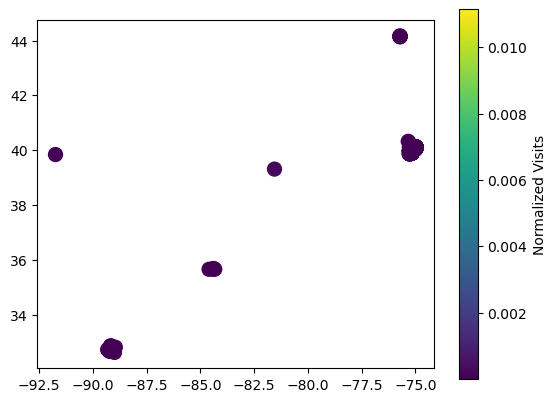

In [32]:
import matplotlib as plt
 
fig, ax = plt.subplots(figsize=(15, 10))
phillysf.plot(
    column='NORMALIZED_VISITS_BY_TOTAL_VISITS',
    legend=True,
    legend_kwds={'label': 'Normalized Visits'},
    cmap='viridis',
    markersize=100
)
plt.title('Locations by Normalized Visits')
plt.axis('equal')